In [1]:
import dataloader
import pandas as pd
import utils
from model import generate_model
import os
import torch
import torch.nn as nn
import torch.optim as optim

from train_wrapper import train_epoch
from test import test

In [2]:
config = utils.load_config()

batch_size = config['dataloader']['batch_size']
num_workers = config['dataloader']['num_workers']
pin_memory = config['dataloader']['pin_memory'] == 1 

In [3]:
#데이터셋 분리(Train, validation, test)
df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna().reset_index(drop=True)
df_oasis = df_dataset[df_dataset['source'] == 'OASIS-3']
df_adni = df_dataset[df_dataset['source'] == 'ADNI']
X_train,X_val,y_train,y_val = dataloader.dataset_split(df_oasis)
X_test = df_adni.drop(labels='group_maxinc',axis=1)
y_test = df_adni['group_maxinc']

/Users/shin/MyDir/MyGit/BrainMR_MCI/dataloader.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['grp'] = (df_dataset['source'].str.replace('OASIS-3','1').str.replace('ADNI','2').apply(pd.to_numeric)*1000


In [4]:
traindata=dataloader.MRIDataset(X_train,y_train)
valdata=dataloader.MRIDataset(X_val,y_val)
testdata=dataloader.MRIDataset(X_test,y_test)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(traindata, batch_size=batch_size, shuffle=True
                              ,num_workers=num_workers,pin_memory = pin_memory)
val_dataloader  = DataLoader(valdata, batch_size=batch_size, shuffle=False
                              ,num_workers=num_workers,pin_memory = pin_memory)
test_dataloader  = DataLoader(testdata, batch_size=1, shuffle=False)

print('train_dataloader : ',len(train_dataloader.dataset))
print('val_dataloader : ',len(val_dataloader.dataset))
print('test_dataloader : ',len(test_dataloader.dataset))

train_dataloader :  659
val_dataloader :  165
test_dataloader :  166


/Users/shin/MyDir/MyGit/BrainMR_MCI/pyenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Feature batch shape: torch.Size([16, 1, 128, 128, 128])
Label: 0


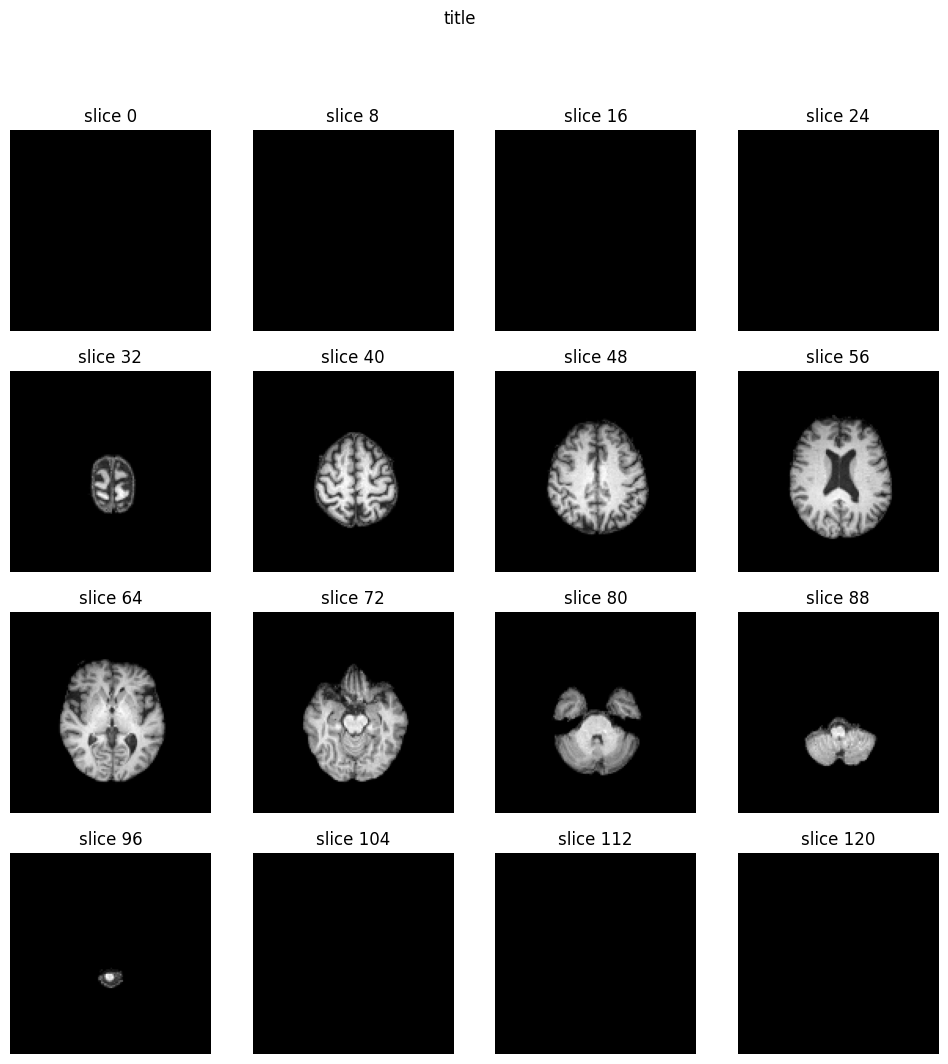

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze() 
label = train_labels[0]
print(f"Label: {label}")
utils.stack_plot(img,rows=4,cols=4,start_with=0,show_every=8)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model, _ = generate_model(model_name='RESNET')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.0001, betas=(0.5, 0.999))
criterion_clf = nn.CrossEntropyLoss().to(device)

cpu


/Users/shin/MyDir/MyGit/BrainMR_MCI/models/resnet.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [7]:
train_epoch(device,train_dataloader,val_dataloader,model,criterion_clf,optimizer,config,epoch=100)

train at epoch 0
Epoch: [0][0/42]	 lr: 0.00010	Time 227.534 (227.534)	Data 99.820 (99.820)	Loss 1.2407 (1.2407)	acc 0.00000 (0.00000)	


In [6]:
checkpoint = torch.load('result/resnet_best.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [7]:
log_path = config['log_path']
test_logger = utils.Logger(os.path.join(log_path, 'valid.log'),['loss','acc'])

test(device,test_dataloader,model,criterion_clf,test_logger)

test
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tenso

(3.2785985469818115, 0.3132530152797699)